In [2]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv

load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [4]:
from lib.json import read_from_json_file

examples = read_from_json_file("relation_examples")

examples

{'/r/RelatedTo': [['rain', 'umbrella'], ['writer', 'book'], ['moon', 'night']],
 '/r/FormOf': [['running', 'run'], ['children', 'child'], ['better', 'good']],
 '/r/IsA': [['dog', 'animal'], ['rose', 'flower'], ['piano', 'instrument']],
 '/r/PartOf': [['keyboard', 'computer'],
  ['leaf', 'tree'],
  ['engine', 'airplane']],
 '/r/HasA': [['car', 'engine'], ['house', 'roof'], ['book', 'pages']],
 '/r/UsedFor': [['key', 'unlock door'],
  ['pen', 'write'],
  ['spoon', 'eat soup']],
 '/r/CapableOf': [['bird', 'fly'], ['teacher', 'teach'], ['car', 'drive']],
 '/r/AtLocation': [['oven', 'cookies'],
  ['library', 'books'],
  ['garage', 'car']],
 '/r/Causes': [['rain', 'flood'],
  ['studying', 'knowledge'],
  ['overheating', 'meltdown']],
 '/r/HasSubevent': [['baking', 'mixing ingredients'],
  ['taking a shower', 'turning on the water'],
  ['writing a letter', 'picking up the pen']],
 '/r/HasFirstSubevent': [['start a car', 'insert key'],
  ['write a letter', 'pick up pen'],
  ['cook a meal', 'ga

In [5]:
from typing import List

PROMPT_INTRO = f"""\
Your task is to determine the correct relation between two nodes A and B.
You will be provided with examples of the possible relations and examples nodes A and B.

Here is a list of the possible relations and examples:
"""

PROMPT_OUTRO = """\
Please choose the correct relation between A and B.

Respond with ONLY the correct relation number. Nothing else is necessary.
"""


def create_prompt(node_a: str, node_b: str, rel_examples: List[str]):
    examples_text = ""
    for i in range(len(rel_examples)):
        rel_example = rel_examples[i]
        example = examples[rel_example]
        examples_text += "Relation " + str(i) + " examples:"
        for relation in example:
            examples_text += f"{relation[0]} -> {relation[1]}"
        examples_text += "\n"

    return f"""\
{PROMPT_INTRO}
{examples_text}

---

Node A: {node_a}
Node B: {node_b}

---

{PROMPT_OUTRO}
"""

In [12]:
import re
from lib.openai import ask_gpt
from lib.relations import RELATIONS
import random


def process_pair(relation, pair, n: int):
    node_a, node_b = pair

    # Ensure the list of relation examples doesn't include the provided relation
    all_relations = list(RELATIONS.keys())
    if relation in all_relations:
        all_relations.remove(relation)

    # Sample n-1 other relations from the list if possible
    if len(all_relations) < n - 1:
        sampled_relations = all_relations  # Use all available relations if fewer than needed
    else:
        sampled_relations = random.sample(all_relations, n - 1)

    # Ensure the provided relation is included
    rel_examples = sampled_relations + [relation]
    random.shuffle(rel_examples)

    prompt = create_prompt(node_a, node_b, rel_examples)

    try:
        response = ask_gpt(prompt)
        response = int(re.search(r'\d+', response).group())

        correct = rel_examples.index(relation) == response

        return {
            "actual_relation": relation,
            "predicted_relation": rel_examples[response],
            "valid_result": correct
        }
    except:
        return {"error": True}

In [13]:
from lib.json import save_to_json_file
from lib.sql.queries import get_unique_random_english_concepts_connected_by_relation
from lib.sql import create_connection

conn = create_connection()

pairs = {}

for relation in RELATIONS.keys():
    pairs[relation] = get_unique_random_english_concepts_connected_by_relation(conn, relation, 100)

save_to_json_file("inputs/analogies", pairs)

In [14]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from lib.sql import create_connection


def test_analogies(n: int = len(RELATIONS.keys())):
    actual_relations = []
    predicted_relations = []
    valid_result = []

    conn = create_connection()

    for relation in RELATIONS.keys():
        print(f"Testing relation: {relation}")
        test_pairs = pairs[relation]

        with ThreadPoolExecutor() as executor:
            futures = []

            for pair in test_pairs:
                futures.append(executor.submit(process_pair, relation, pair, n))

            for future in tqdm(as_completed(futures), total=len(futures)):
                result = future.result()

                if "error" in result:
                    print("error :(")
                    continue

                actual_relations.append(result["actual_relation"])
                predicted_relations.append(result["predicted_relation"])
                valid_result.append(result["valid_result"])

    return actual_relations, predicted_relations, valid_result

In [15]:
actual_relations, predicted_relations, valid_result = test_analogies()

save_to_json_file("results/analogies_full",
                  {"actual_relations": actual_relations, "predicted_relations": predicted_relations, })

Testing relation: /r/RelatedTo


100%|██████████| 100/100 [00:02<00:00, 34.68it/s]


Testing relation: /r/FormOf


100%|██████████| 100/100 [00:02<00:00, 34.59it/s]


Testing relation: /r/IsA


100%|██████████| 100/100 [00:02<00:00, 33.64it/s]


Testing relation: /r/PartOf


100%|██████████| 100/100 [00:02<00:00, 34.34it/s]


Testing relation: /r/HasA


100%|██████████| 100/100 [00:02<00:00, 33.97it/s]


Testing relation: /r/UsedFor


100%|██████████| 100/100 [00:02<00:00, 34.33it/s]


Testing relation: /r/CapableOf


100%|██████████| 100/100 [00:02<00:00, 34.17it/s]


Testing relation: /r/AtLocation


100%|██████████| 100/100 [00:03<00:00, 30.79it/s]


Testing relation: /r/Causes


100%|██████████| 100/100 [00:02<00:00, 33.49it/s]


Testing relation: /r/HasSubevent


100%|██████████| 100/100 [00:02<00:00, 35.18it/s]


Testing relation: /r/HasFirstSubevent


100%|██████████| 100/100 [00:02<00:00, 35.39it/s]


Testing relation: /r/HasLastSubevent


100%|██████████| 100/100 [00:02<00:00, 35.32it/s]


Testing relation: /r/HasPrerequisite


100%|██████████| 100/100 [00:02<00:00, 37.19it/s]


Testing relation: /r/HasProperty


100%|██████████| 100/100 [00:02<00:00, 36.18it/s]


Testing relation: /r/MotivatedByGoal


100%|██████████| 100/100 [00:02<00:00, 36.34it/s]


Testing relation: /r/Desires


100%|██████████| 100/100 [00:02<00:00, 33.69it/s]


Testing relation: /r/CreatedBy


100%|██████████| 100/100 [00:03<00:00, 32.84it/s]


Testing relation: /r/Synonym


100%|██████████| 100/100 [00:02<00:00, 34.35it/s]


Testing relation: /r/Antonym


100%|██████████| 100/100 [00:03<00:00, 28.78it/s]


Testing relation: /r/DistinctFrom


100%|██████████| 100/100 [00:02<00:00, 34.02it/s]


Testing relation: /r/DerivedFrom


100%|██████████| 100/100 [00:03<00:00, 33.18it/s]


Testing relation: /r/DefinedAs


100%|██████████| 100/100 [00:02<00:00, 34.21it/s]


Testing relation: /r/HasContext


100%|██████████| 100/100 [00:02<00:00, 33.69it/s]


Testing relation: /r/SimilarTo


100%|██████████| 100/100 [00:02<00:00, 35.91it/s]


Testing relation: /r/EtymologicallyRelatedTo


100%|██████████| 100/100 [00:03<00:00, 32.97it/s]


Testing relation: /r/CausesDesire


100%|██████████| 100/100 [00:03<00:00, 27.86it/s]


Testing relation: /r/MadeOf


100%|██████████| 100/100 [00:02<00:00, 36.06it/s]


Testing relation: /r/ReceivesAction


100%|██████████| 100/100 [00:03<00:00, 31.68it/s]


In [16]:
save_to_json_file("results/analogies_full",
                  {"actual_relations": actual_relations, "predicted_relations": predicted_relations, })

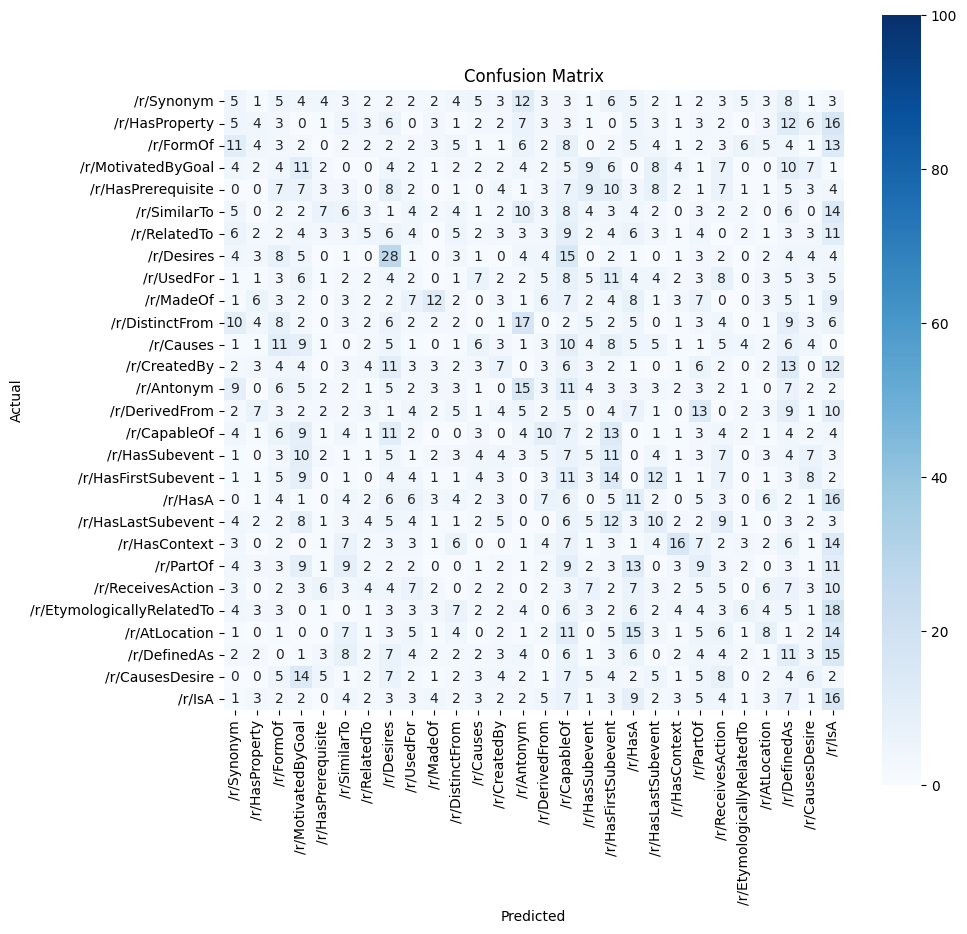

In [17]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

filtered_relations = list(set(actual_relations))

plt.rcdefaults()

# Generate a confusion matrix
cm = confusion_matrix(actual_relations, predicted_relations, labels=filtered_relations)
cm_df = pd.DataFrame(cm, index=filtered_relations, columns=filtered_relations)

plt.figure(figsize=(10, 10))
ax = sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", square=True, vmin=0, vmax=100)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [18]:

from sklearn.metrics import cohen_kappa_score

# Convert the confusion matrix into actual and predicted labels
actual = []
predicted = []

for i in range(len(cm)):
    for j in range(len(cm[i])):
        actual.extend([i] * cm[i][j])
        predicted.extend([j] * cm[i][j])

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(actual, predicted)
print(f"Cohen's Kappa: {kappa}")

Cohen's Kappa: 0.050000000000000044


In [20]:
actual_relations, predicted_relations, valid_result = test_analogies(5)

save_to_json_file("results/analogies_5",
                  {"actual_relations": actual_relations, "predicted_relations": predicted_relations, })

Testing relation: /r/RelatedTo


100%|██████████| 100/100 [00:04<00:00, 24.25it/s]


Testing relation: /r/FormOf


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


Testing relation: /r/IsA


100%|██████████| 100/100 [00:03<00:00, 26.39it/s]


Testing relation: /r/PartOf


100%|██████████| 100/100 [00:03<00:00, 31.07it/s]


Testing relation: /r/HasA


100%|██████████| 100/100 [00:02<00:00, 33.76it/s]


Testing relation: /r/UsedFor


100%|██████████| 100/100 [00:03<00:00, 31.82it/s]


Testing relation: /r/CapableOf


100%|██████████| 100/100 [00:03<00:00, 31.68it/s]


Testing relation: /r/AtLocation


100%|██████████| 100/100 [00:02<00:00, 33.46it/s]


Testing relation: /r/Causes


100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


Testing relation: /r/HasSubevent


100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Testing relation: /r/HasFirstSubevent


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


Testing relation: /r/HasLastSubevent


100%|██████████| 100/100 [00:03<00:00, 33.09it/s]


Testing relation: /r/HasPrerequisite


100%|██████████| 100/100 [00:03<00:00, 33.03it/s]


Testing relation: /r/HasProperty


100%|██████████| 100/100 [00:03<00:00, 33.00it/s]


Testing relation: /r/MotivatedByGoal


100%|██████████| 100/100 [00:02<00:00, 33.46it/s]


Testing relation: /r/Desires


100%|██████████| 100/100 [00:02<00:00, 36.32it/s]


Testing relation: /r/CreatedBy


100%|██████████| 100/100 [00:02<00:00, 33.40it/s]


Testing relation: /r/Synonym


100%|██████████| 100/100 [00:02<00:00, 35.17it/s]


Testing relation: /r/Antonym


100%|██████████| 100/100 [00:02<00:00, 33.37it/s]


Testing relation: /r/DistinctFrom


100%|██████████| 100/100 [00:02<00:00, 34.16it/s]


Testing relation: /r/DerivedFrom


100%|██████████| 100/100 [00:02<00:00, 34.52it/s]


Testing relation: /r/DefinedAs


100%|██████████| 100/100 [00:02<00:00, 33.86it/s]


Testing relation: /r/HasContext


100%|██████████| 100/100 [00:03<00:00, 33.18it/s]


Testing relation: /r/SimilarTo


100%|██████████| 100/100 [00:03<00:00, 29.15it/s]


Testing relation: /r/EtymologicallyRelatedTo


100%|██████████| 100/100 [00:02<00:00, 34.59it/s]


Testing relation: /r/CausesDesire


100%|██████████| 100/100 [00:02<00:00, 33.87it/s]


Testing relation: /r/MadeOf


100%|██████████| 100/100 [00:03<00:00, 32.96it/s]


Testing relation: /r/ReceivesAction


100%|██████████| 100/100 [00:02<00:00, 35.09it/s]


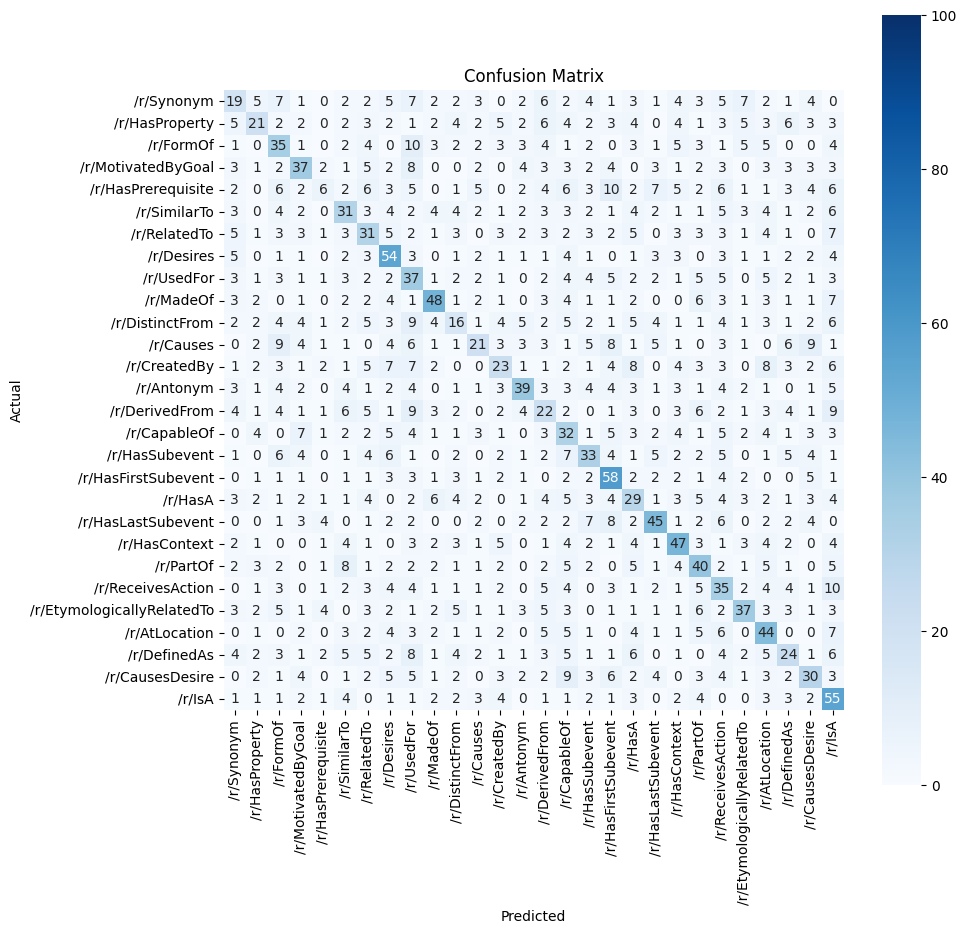

In [21]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

filtered_relations = list(set(actual_relations))

plt.rcdefaults()

# Generate a confusion matrix
cm = confusion_matrix(actual_relations, predicted_relations, labels=filtered_relations)
cm_df = pd.DataFrame(cm, index=filtered_relations, columns=filtered_relations)

plt.figure(figsize=(10, 10))
ax = sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", square=True, vmin=0, vmax=100)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()